In [1]:
import os
import pickle
import numpy as np

def load_cifar10_batch(filename):
    with open(filename, 'rb') as f:
        batch = pickle.load(f, encoding='bytes')
        images = batch[b'data'].reshape(-1, 3, 32, 32)  
        labels = np.array(batch[b'labels'])
        return images, labels

def load_cifar10_dataset(data_dir):
    train_images = []
    train_labels = []
    for i in range(1, 6):
        batch_file = os.path.join(data_dir, f'data_batch_{i}')
        imgs, lbls = load_cifar10_batch(batch_file)
        train_images.append(imgs)
        train_labels.append(lbls)
    train_images = np.concatenate(train_images, axis=0)
    train_labels = np.concatenate(train_labels, axis=0)

    # 加载测试集
    test_file = os.path.join(data_dir, 'test_batch')
    test_images, test_labels = load_cifar10_batch(test_file)

    return train_images, train_labels, test_images, test_labels

# 调用加载函数
data_dir = '../cifar10/cifar-10-batches-py'
train_images, train_labels, test_images, test_labels = load_cifar10_dataset(data_dir)

In [2]:
print(train_images.shape, train_labels.shape)

(50000, 3, 32, 32) (50000,)


In [3]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

class CIFAR10Dataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img = self.images[idx]
        img = np.transpose(img, (1, 2, 0))  
        img = Image.fromarray(img)        
        label = self.labels[idx]
        if self.transform:
            img = self.transform(img)
        return img, torch.tensor(label, dtype=torch.long)

In [4]:
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [5]:
# 创建 Dataset
train_dataset = CIFAR10Dataset(train_images[:45000], train_labels[:45000], transform=train_transform)
dev_dataset=CIFAR10Dataset(train_images[45000:], train_labels[45000:], transform=test_transform)
test_dataset = CIFAR10Dataset(test_images, test_labels, transform=test_transform)

# 创建 DataLoader
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=0)
dev_loader = DataLoader(dev_dataset, batch_size=128, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False, num_workers=0)


In [6]:
# 获取一个 batch
images, labels = next(iter(train_loader))

# 查看最小值和最大值
print("Min value:", images.min().item())
print("Max value:", images.max().item())

Min value: -1.0
Max value: 1.0


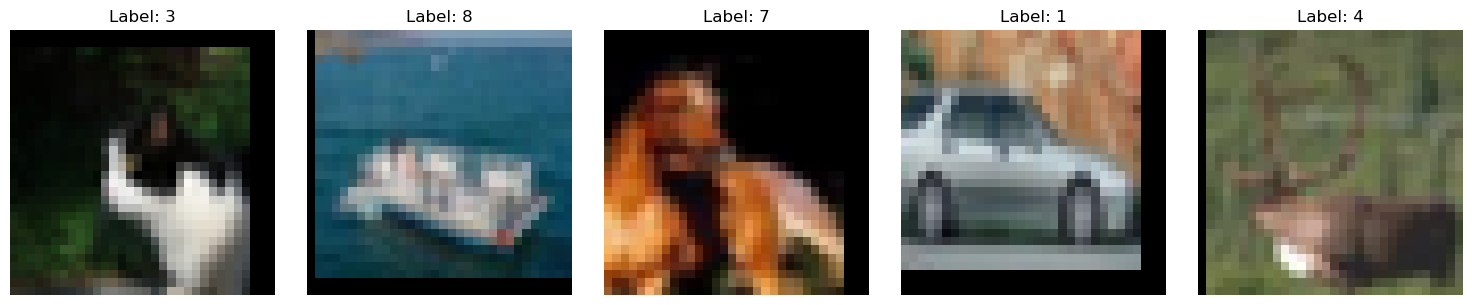

In [7]:
import matplotlib.pyplot as plt
import torchvision

# 如果你使用了 Normalize，需要定义逆变换
mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]
inv_normalize = torchvision.transforms.Normalize(
    mean=[-m/s for m, s in zip(mean, std)],
    std=[1/s for s in std]
)

# 获取一个 batch
images, labels = next(iter(train_loader))

# 只看前5张
fig, axs = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    img = inv_normalize(images[i]).clamp(0, 1)  # 逆归一化并裁剪
    img = img.permute(1, 2, 0).cpu().numpy()    # CHW -> HWC
    axs[i].imshow(img)
    axs[i].set_title(f"Label: {labels[i].item()}")
    axs[i].axis('off')

plt.tight_layout()
plt.show()


In [8]:
print(len(train_dataset), len(dev_dataset))

45000 5000


In [9]:
import torch.nn as nn
import torch
import torch.nn.functional as F

class Residual(nn.Module):  #@save
    def __init__(self, input_channels, num_channels,
                 use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, num_channels,
                               kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.Conv2d(num_channels, num_channels,
                               kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels, num_channels,
                                   kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)

    def forward(self, X):
        Y = torch.sigmoid(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return torch.sigmoid(Y)

In [10]:
class ResNetSmall(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),  # 输出: [B,64,32,32]
            nn.BatchNorm2d(64),
            nn.Sigmoid(),

            # Stage 1
            Residual(64, 64),
            Residual(64, 64),

            # Stage 2
            Residual(64, 128, use_1x1conv=True, strides=2),  
            Residual(128, 128),

            # Stage 3
            Residual(128, 256, use_1x1conv=True, strides=2), 
            Residual(256, 256),

            nn.AdaptiveAvgPool2d((1, 1)),  
            nn.Flatten(),                 
            nn.Linear(256, num_classes)   
        )

    def forward(self, x):
        return self.net(x)

In [11]:
import torch.optim as optim
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNetSmall().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [12]:
print(device)

cuda


In [13]:
from tqdm import tqdm
train_losses, dev_losses = [], []
train_accuracies, dev_accuracies = [], []
best_acc = 0.0
num_epochs = 100

for epoch in range(num_epochs):
    model.train()
    total_loss, correct, total = 0, 0, 0

    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    for inputs, labels in pbar:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_loss = total_loss / total
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # 验证阶段
    model.eval()
    dev_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for inputs, labels in dev_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            dev_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    dev_loss /= total
    dev_acc = correct / total
    dev_losses.append(dev_loss)
    dev_accuracies.append(dev_acc)

    print(f"Epoch {epoch+1} => Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | Val Loss: {dev_loss:.4f}, Acc: {dev_acc:.4f}")

    if dev_acc > best_acc:
        best_acc = dev_acc
        torch.save(model.state_dict(), 'best_model.pth')

Epoch 1/100: 100%|██████████| 352/352 [00:30<00:00, 11.58it/s]


Epoch 1 => Train Loss: 1.8722, Acc: 0.2835 | Val Loss: 2.4262, Acc: 0.1364


Epoch 2/100: 100%|██████████| 352/352 [00:29<00:00, 12.02it/s]


Epoch 2 => Train Loss: 1.5520, Acc: 0.4186 | Val Loss: 2.1067, Acc: 0.3062


Epoch 3/100: 100%|██████████| 352/352 [00:29<00:00, 12.04it/s]


Epoch 3 => Train Loss: 1.3187, Acc: 0.5147 | Val Loss: 3.5965, Acc: 0.1438


Epoch 4/100: 100%|██████████| 352/352 [00:29<00:00, 11.96it/s]


Epoch 4 => Train Loss: 1.1370, Acc: 0.5868 | Val Loss: 2.7504, Acc: 0.2158


Epoch 5/100: 100%|██████████| 352/352 [00:29<00:00, 11.96it/s]


Epoch 5 => Train Loss: 1.0364, Acc: 0.6261 | Val Loss: 2.1658, Acc: 0.3640


Epoch 6/100: 100%|██████████| 352/352 [00:30<00:00, 11.68it/s]


Epoch 6 => Train Loss: 0.9459, Acc: 0.6570 | Val Loss: 1.4613, Acc: 0.5032


Epoch 7/100: 100%|██████████| 352/352 [00:30<00:00, 11.63it/s]


Epoch 7 => Train Loss: 0.8758, Acc: 0.6842 | Val Loss: 6.3668, Acc: 0.0994


Epoch 8/100: 100%|██████████| 352/352 [00:37<00:00,  9.49it/s]


Epoch 8 => Train Loss: 0.8135, Acc: 0.7064 | Val Loss: 3.9433, Acc: 0.2016


Epoch 9/100: 100%|██████████| 352/352 [00:42<00:00,  8.26it/s]


Epoch 9 => Train Loss: 0.7635, Acc: 0.7282 | Val Loss: 4.9386, Acc: 0.2310


Epoch 10/100: 100%|██████████| 352/352 [00:55<00:00,  6.35it/s]


Epoch 10 => Train Loss: 0.7133, Acc: 0.7495 | Val Loss: 1.7336, Acc: 0.4758


Epoch 11/100: 100%|██████████| 352/352 [00:34<00:00, 10.20it/s]


Epoch 11 => Train Loss: 0.6770, Acc: 0.7641 | Val Loss: 2.1790, Acc: 0.4094


Epoch 12/100: 100%|██████████| 352/352 [00:43<00:00,  8.01it/s]


Epoch 12 => Train Loss: 0.6369, Acc: 0.7779 | Val Loss: 1.4149, Acc: 0.5504


Epoch 13/100: 100%|██████████| 352/352 [00:35<00:00, 10.00it/s]


Epoch 13 => Train Loss: 0.6095, Acc: 0.7866 | Val Loss: 2.3810, Acc: 0.4082


Epoch 14/100: 100%|██████████| 352/352 [00:32<00:00, 10.73it/s]


Epoch 14 => Train Loss: 0.5718, Acc: 0.8000 | Val Loss: 1.8916, Acc: 0.5120


Epoch 15/100: 100%|██████████| 352/352 [00:31<00:00, 11.20it/s]


Epoch 15 => Train Loss: 0.5508, Acc: 0.8096 | Val Loss: 2.3715, Acc: 0.4054


Epoch 16/100: 100%|██████████| 352/352 [00:32<00:00, 10.92it/s]


Epoch 16 => Train Loss: 0.5317, Acc: 0.8154 | Val Loss: 1.4761, Acc: 0.6142


Epoch 17/100: 100%|██████████| 352/352 [00:32<00:00, 10.77it/s]


Epoch 17 => Train Loss: 0.5066, Acc: 0.8260 | Val Loss: 2.3259, Acc: 0.4536


Epoch 18/100: 100%|██████████| 352/352 [00:32<00:00, 10.90it/s]


Epoch 18 => Train Loss: 0.4886, Acc: 0.8311 | Val Loss: 3.7666, Acc: 0.2956


Epoch 19/100: 100%|██████████| 352/352 [00:32<00:00, 10.82it/s]


Epoch 19 => Train Loss: 0.4672, Acc: 0.8401 | Val Loss: 2.0718, Acc: 0.5096


Epoch 20/100: 100%|██████████| 352/352 [00:32<00:00, 10.71it/s]


Epoch 20 => Train Loss: 0.4527, Acc: 0.8429 | Val Loss: 9.2774, Acc: 0.1338


Epoch 21/100: 100%|██████████| 352/352 [00:33<00:00, 10.56it/s]


Epoch 21 => Train Loss: 0.4351, Acc: 0.8484 | Val Loss: 2.8213, Acc: 0.3402


Epoch 22/100: 100%|██████████| 352/352 [00:33<00:00, 10.51it/s]


Epoch 22 => Train Loss: 0.4215, Acc: 0.8543 | Val Loss: 1.3749, Acc: 0.5882


Epoch 23/100: 100%|██████████| 352/352 [00:33<00:00, 10.41it/s]


Epoch 23 => Train Loss: 0.4106, Acc: 0.8578 | Val Loss: 1.6953, Acc: 0.5388


Epoch 24/100: 100%|██████████| 352/352 [00:33<00:00, 10.45it/s]


Epoch 24 => Train Loss: 0.3940, Acc: 0.8639 | Val Loss: 2.3476, Acc: 0.4166


Epoch 25/100: 100%|██████████| 352/352 [00:33<00:00, 10.38it/s]


Epoch 25 => Train Loss: 0.3828, Acc: 0.8678 | Val Loss: 1.0958, Acc: 0.6772


Epoch 26/100: 100%|██████████| 352/352 [00:34<00:00, 10.32it/s]


Epoch 26 => Train Loss: 0.3645, Acc: 0.8735 | Val Loss: 2.2306, Acc: 0.4406


Epoch 27/100: 100%|██████████| 352/352 [00:34<00:00, 10.12it/s]


Epoch 27 => Train Loss: 0.3536, Acc: 0.8769 | Val Loss: 1.6022, Acc: 0.5560


Epoch 28/100: 100%|██████████| 352/352 [00:34<00:00, 10.31it/s]


Epoch 28 => Train Loss: 0.3463, Acc: 0.8794 | Val Loss: 1.8728, Acc: 0.5778


Epoch 29/100: 100%|██████████| 352/352 [00:34<00:00, 10.27it/s]


Epoch 29 => Train Loss: 0.3361, Acc: 0.8822 | Val Loss: 2.7026, Acc: 0.3690


Epoch 30/100: 100%|██████████| 352/352 [00:32<00:00, 10.68it/s]


Epoch 30 => Train Loss: 0.3270, Acc: 0.8874 | Val Loss: 3.8813, Acc: 0.3270


Epoch 31/100: 100%|██████████| 352/352 [00:32<00:00, 10.91it/s]


Epoch 31 => Train Loss: 0.3122, Acc: 0.8915 | Val Loss: 2.8338, Acc: 0.4338


Epoch 32/100: 100%|██████████| 352/352 [00:31<00:00, 11.10it/s]


Epoch 32 => Train Loss: 0.3060, Acc: 0.8921 | Val Loss: 4.7103, Acc: 0.3118


Epoch 33/100: 100%|██████████| 352/352 [00:31<00:00, 11.16it/s]


Epoch 33 => Train Loss: 0.2970, Acc: 0.8970 | Val Loss: 3.0941, Acc: 0.4242


Epoch 34/100: 100%|██████████| 352/352 [00:31<00:00, 11.29it/s]


Epoch 34 => Train Loss: 0.2900, Acc: 0.8985 | Val Loss: 4.5343, Acc: 0.3424


Epoch 35/100: 100%|██████████| 352/352 [00:30<00:00, 11.36it/s]


Epoch 35 => Train Loss: 0.2758, Acc: 0.9050 | Val Loss: 2.1153, Acc: 0.5642


Epoch 36/100: 100%|██████████| 352/352 [00:30<00:00, 11.38it/s]


Epoch 36 => Train Loss: 0.2719, Acc: 0.9049 | Val Loss: 3.0226, Acc: 0.4186


Epoch 37/100: 100%|██████████| 352/352 [00:31<00:00, 11.26it/s]


Epoch 37 => Train Loss: 0.2674, Acc: 0.9066 | Val Loss: 2.5284, Acc: 0.5548


Epoch 38/100: 100%|██████████| 352/352 [00:31<00:00, 11.04it/s]


Epoch 38 => Train Loss: 0.2556, Acc: 0.9104 | Val Loss: 1.9624, Acc: 0.5676


Epoch 39/100: 100%|██████████| 352/352 [00:31<00:00, 11.27it/s]


Epoch 39 => Train Loss: 0.2587, Acc: 0.9097 | Val Loss: 2.4153, Acc: 0.5524


Epoch 40/100: 100%|██████████| 352/352 [00:30<00:00, 11.38it/s]


Epoch 40 => Train Loss: 0.2422, Acc: 0.9155 | Val Loss: 0.8671, Acc: 0.7622


Epoch 41/100: 100%|██████████| 352/352 [00:30<00:00, 11.39it/s]


Epoch 41 => Train Loss: 0.2358, Acc: 0.9180 | Val Loss: 2.7389, Acc: 0.4204


Epoch 42/100: 100%|██████████| 352/352 [00:31<00:00, 11.31it/s]


Epoch 42 => Train Loss: 0.2332, Acc: 0.9195 | Val Loss: 4.1779, Acc: 0.4082


Epoch 43/100: 100%|██████████| 352/352 [00:30<00:00, 11.47it/s]


Epoch 43 => Train Loss: 0.2213, Acc: 0.9224 | Val Loss: 1.5167, Acc: 0.6354


Epoch 44/100: 100%|██████████| 352/352 [00:30<00:00, 11.46it/s]


Epoch 44 => Train Loss: 0.2186, Acc: 0.9245 | Val Loss: 2.2223, Acc: 0.5402


Epoch 45/100: 100%|██████████| 352/352 [00:30<00:00, 11.38it/s]


Epoch 45 => Train Loss: 0.2155, Acc: 0.9234 | Val Loss: 2.9383, Acc: 0.4182


Epoch 46/100: 100%|██████████| 352/352 [00:30<00:00, 11.45it/s]


Epoch 46 => Train Loss: 0.2090, Acc: 0.9276 | Val Loss: 2.0446, Acc: 0.5524


Epoch 47/100: 100%|██████████| 352/352 [00:30<00:00, 11.50it/s]


Epoch 47 => Train Loss: 0.2024, Acc: 0.9290 | Val Loss: 2.7595, Acc: 0.5386


Epoch 48/100: 100%|██████████| 352/352 [00:30<00:00, 11.57it/s]


Epoch 48 => Train Loss: 0.1978, Acc: 0.9317 | Val Loss: 2.7507, Acc: 0.5216


Epoch 49/100: 100%|██████████| 352/352 [00:30<00:00, 11.36it/s]


Epoch 49 => Train Loss: 0.1927, Acc: 0.9324 | Val Loss: 4.5390, Acc: 0.3042


Epoch 50/100: 100%|██████████| 352/352 [00:30<00:00, 11.53it/s]


Epoch 50 => Train Loss: 0.1874, Acc: 0.9337 | Val Loss: 3.0215, Acc: 0.5436


Epoch 51/100: 100%|██████████| 352/352 [00:30<00:00, 11.57it/s]


Epoch 51 => Train Loss: 0.1809, Acc: 0.9364 | Val Loss: 2.2337, Acc: 0.5808


Epoch 52/100: 100%|██████████| 352/352 [00:30<00:00, 11.47it/s]


Epoch 52 => Train Loss: 0.1815, Acc: 0.9358 | Val Loss: 3.1912, Acc: 0.4646


Epoch 53/100: 100%|██████████| 352/352 [00:30<00:00, 11.41it/s]


Epoch 53 => Train Loss: 0.1717, Acc: 0.9397 | Val Loss: 1.9889, Acc: 0.6174


Epoch 54/100: 100%|██████████| 352/352 [00:30<00:00, 11.50it/s]


Epoch 54 => Train Loss: 0.1732, Acc: 0.9390 | Val Loss: 5.6120, Acc: 0.3202


Epoch 55/100: 100%|██████████| 352/352 [00:31<00:00, 11.34it/s]


Epoch 55 => Train Loss: 0.1646, Acc: 0.9428 | Val Loss: 1.2646, Acc: 0.7154


Epoch 56/100: 100%|██████████| 352/352 [00:30<00:00, 11.46it/s]


Epoch 56 => Train Loss: 0.1629, Acc: 0.9422 | Val Loss: 2.5470, Acc: 0.5400


Epoch 57/100: 100%|██████████| 352/352 [00:30<00:00, 11.43it/s]


Epoch 57 => Train Loss: 0.1571, Acc: 0.9457 | Val Loss: 1.3093, Acc: 0.7152


Epoch 58/100: 100%|██████████| 352/352 [00:31<00:00, 11.29it/s]


Epoch 58 => Train Loss: 0.1520, Acc: 0.9465 | Val Loss: 3.1370, Acc: 0.5432


Epoch 59/100: 100%|██████████| 352/352 [00:30<00:00, 11.41it/s]


Epoch 59 => Train Loss: 0.1531, Acc: 0.9455 | Val Loss: 2.3786, Acc: 0.6448


Epoch 60/100: 100%|██████████| 352/352 [00:30<00:00, 11.38it/s]


Epoch 60 => Train Loss: 0.1424, Acc: 0.9487 | Val Loss: 1.6548, Acc: 0.6620


Epoch 61/100: 100%|██████████| 352/352 [00:31<00:00, 11.33it/s]


Epoch 61 => Train Loss: 0.1410, Acc: 0.9502 | Val Loss: 3.4838, Acc: 0.4376


Epoch 62/100: 100%|██████████| 352/352 [00:30<00:00, 11.50it/s]


Epoch 62 => Train Loss: 0.1379, Acc: 0.9497 | Val Loss: 1.5183, Acc: 0.7134


Epoch 63/100: 100%|██████████| 352/352 [00:30<00:00, 11.41it/s]


Epoch 63 => Train Loss: 0.1378, Acc: 0.9512 | Val Loss: 3.0679, Acc: 0.5012


Epoch 64/100: 100%|██████████| 352/352 [00:30<00:00, 11.40it/s]


Epoch 64 => Train Loss: 0.1295, Acc: 0.9534 | Val Loss: 1.2041, Acc: 0.7490


Epoch 65/100: 100%|██████████| 352/352 [00:30<00:00, 11.38it/s]


Epoch 65 => Train Loss: 0.1281, Acc: 0.9549 | Val Loss: 2.5560, Acc: 0.5768


Epoch 66/100: 100%|██████████| 352/352 [00:31<00:00, 11.06it/s]


Epoch 66 => Train Loss: 0.1274, Acc: 0.9556 | Val Loss: 2.0004, Acc: 0.6198


Epoch 67/100: 100%|██████████| 352/352 [00:32<00:00, 10.88it/s]


Epoch 67 => Train Loss: 0.1199, Acc: 0.9571 | Val Loss: 4.9169, Acc: 0.4048


Epoch 68/100: 100%|██████████| 352/352 [00:32<00:00, 10.78it/s]


Epoch 68 => Train Loss: 0.1218, Acc: 0.9568 | Val Loss: 2.0530, Acc: 0.6104


Epoch 69/100: 100%|██████████| 352/352 [00:32<00:00, 10.84it/s]


Epoch 69 => Train Loss: 0.1130, Acc: 0.9599 | Val Loss: 2.0039, Acc: 0.6404


Epoch 70/100: 100%|██████████| 352/352 [00:32<00:00, 10.71it/s]


Epoch 70 => Train Loss: 0.1148, Acc: 0.9579 | Val Loss: 2.5823, Acc: 0.6222


Epoch 71/100: 100%|██████████| 352/352 [00:33<00:00, 10.50it/s]


Epoch 71 => Train Loss: 0.1101, Acc: 0.9602 | Val Loss: 1.0351, Acc: 0.7830


Epoch 72/100: 100%|██████████| 352/352 [00:33<00:00, 10.36it/s]


Epoch 72 => Train Loss: 0.1098, Acc: 0.9597 | Val Loss: 0.6926, Acc: 0.8248


Epoch 73/100: 100%|██████████| 352/352 [00:34<00:00, 10.22it/s]


Epoch 73 => Train Loss: 0.1038, Acc: 0.9630 | Val Loss: 3.3091, Acc: 0.5050


Epoch 74/100: 100%|██████████| 352/352 [00:34<00:00, 10.21it/s]


Epoch 74 => Train Loss: 0.1090, Acc: 0.9613 | Val Loss: 3.5221, Acc: 0.5200


Epoch 75/100: 100%|██████████| 352/352 [00:34<00:00, 10.13it/s]


Epoch 75 => Train Loss: 0.1028, Acc: 0.9632 | Val Loss: 2.1021, Acc: 0.6728


Epoch 76/100: 100%|██████████| 352/352 [00:34<00:00, 10.27it/s]


Epoch 76 => Train Loss: 0.0977, Acc: 0.9654 | Val Loss: 1.7404, Acc: 0.6618


Epoch 77/100: 100%|██████████| 352/352 [00:34<00:00, 10.13it/s]


Epoch 77 => Train Loss: 0.1009, Acc: 0.9639 | Val Loss: 2.1196, Acc: 0.6406


Epoch 78/100: 100%|██████████| 352/352 [00:35<00:00, 10.05it/s]


Epoch 78 => Train Loss: 0.0939, Acc: 0.9663 | Val Loss: 1.2213, Acc: 0.7728


Epoch 79/100: 100%|██████████| 352/352 [00:34<00:00, 10.06it/s]


Epoch 79 => Train Loss: 0.0929, Acc: 0.9664 | Val Loss: 2.1187, Acc: 0.6934


Epoch 80/100: 100%|██████████| 352/352 [00:35<00:00,  9.97it/s]


Epoch 80 => Train Loss: 0.0897, Acc: 0.9680 | Val Loss: 2.3204, Acc: 0.6328


Epoch 81/100: 100%|██████████| 352/352 [00:34<00:00, 10.22it/s]


Epoch 81 => Train Loss: 0.0830, Acc: 0.9706 | Val Loss: 1.7709, Acc: 0.6820


Epoch 82/100: 100%|██████████| 352/352 [00:34<00:00, 10.19it/s]


Epoch 82 => Train Loss: 0.0905, Acc: 0.9674 | Val Loss: 1.7088, Acc: 0.7142


Epoch 83/100: 100%|██████████| 352/352 [00:34<00:00, 10.18it/s]


Epoch 83 => Train Loss: 0.0899, Acc: 0.9680 | Val Loss: 1.4730, Acc: 0.6832


Epoch 84/100: 100%|██████████| 352/352 [00:34<00:00, 10.13it/s]


Epoch 84 => Train Loss: 0.0813, Acc: 0.9711 | Val Loss: 0.6383, Acc: 0.8470


Epoch 85/100: 100%|██████████| 352/352 [00:32<00:00, 10.84it/s]


Epoch 85 => Train Loss: 0.0819, Acc: 0.9713 | Val Loss: 1.1442, Acc: 0.8010


Epoch 86/100: 100%|██████████| 352/352 [00:30<00:00, 11.37it/s]


Epoch 86 => Train Loss: 0.0824, Acc: 0.9707 | Val Loss: 3.9511, Acc: 0.5096


Epoch 87/100: 100%|██████████| 352/352 [00:29<00:00, 11.75it/s]


Epoch 87 => Train Loss: 0.0794, Acc: 0.9717 | Val Loss: 3.3672, Acc: 0.5138


Epoch 88/100: 100%|██████████| 352/352 [00:29<00:00, 11.79it/s]


Epoch 88 => Train Loss: 0.0768, Acc: 0.9722 | Val Loss: 1.8783, Acc: 0.7018


Epoch 89/100: 100%|██████████| 352/352 [00:29<00:00, 11.84it/s]


Epoch 89 => Train Loss: 0.0755, Acc: 0.9731 | Val Loss: 2.9247, Acc: 0.5704


Epoch 90/100: 100%|██████████| 352/352 [00:28<00:00, 12.19it/s]


Epoch 90 => Train Loss: 0.0705, Acc: 0.9751 | Val Loss: 1.4887, Acc: 0.7376


Epoch 91/100: 100%|██████████| 352/352 [00:29<00:00, 12.01it/s]


Epoch 91 => Train Loss: 0.0765, Acc: 0.9726 | Val Loss: 1.3663, Acc: 0.7504


Epoch 92/100: 100%|██████████| 352/352 [00:29<00:00, 12.05it/s]


Epoch 92 => Train Loss: 0.0769, Acc: 0.9723 | Val Loss: 3.7250, Acc: 0.5128


Epoch 93/100: 100%|██████████| 352/352 [00:29<00:00, 11.98it/s]


Epoch 93 => Train Loss: 0.0727, Acc: 0.9740 | Val Loss: 2.3529, Acc: 0.6386


Epoch 94/100: 100%|██████████| 352/352 [00:29<00:00, 12.12it/s]


Epoch 94 => Train Loss: 0.0724, Acc: 0.9742 | Val Loss: 0.7663, Acc: 0.8456


Epoch 95/100: 100%|██████████| 352/352 [00:29<00:00, 12.11it/s]


Epoch 95 => Train Loss: 0.0731, Acc: 0.9735 | Val Loss: 1.9346, Acc: 0.7050


Epoch 96/100: 100%|██████████| 352/352 [00:28<00:00, 12.21it/s]


Epoch 96 => Train Loss: 0.0695, Acc: 0.9750 | Val Loss: 1.7376, Acc: 0.6802


Epoch 97/100: 100%|██████████| 352/352 [00:28<00:00, 12.28it/s]


Epoch 97 => Train Loss: 0.0674, Acc: 0.9762 | Val Loss: 1.1223, Acc: 0.8042


Epoch 98/100: 100%|██████████| 352/352 [00:28<00:00, 12.44it/s]


Epoch 98 => Train Loss: 0.0666, Acc: 0.9768 | Val Loss: 1.7650, Acc: 0.7278


Epoch 99/100: 100%|██████████| 352/352 [00:28<00:00, 12.42it/s]


Epoch 99 => Train Loss: 0.0635, Acc: 0.9776 | Val Loss: 1.2987, Acc: 0.7634


Epoch 100/100: 100%|██████████| 352/352 [00:28<00:00, 12.20it/s]


Epoch 100 => Train Loss: 0.0645, Acc: 0.9778 | Val Loss: 1.7574, Acc: 0.7074


In [14]:
import numpy as np

# 将4个列表转为 numpy 数组并堆叠为 (epochs, 4) 的二维数组
results = np.column_stack((train_losses, dev_losses, train_accuracies, dev_accuracies))

# 保存为 txt 文件，添加列名
np.savetxt("adam_sigmoid.txt", results, 
           header="Train_Loss Validation_Loss Train_Accuracy Validation_Accuracy", 
           fmt='%.6f', delimiter='\t')

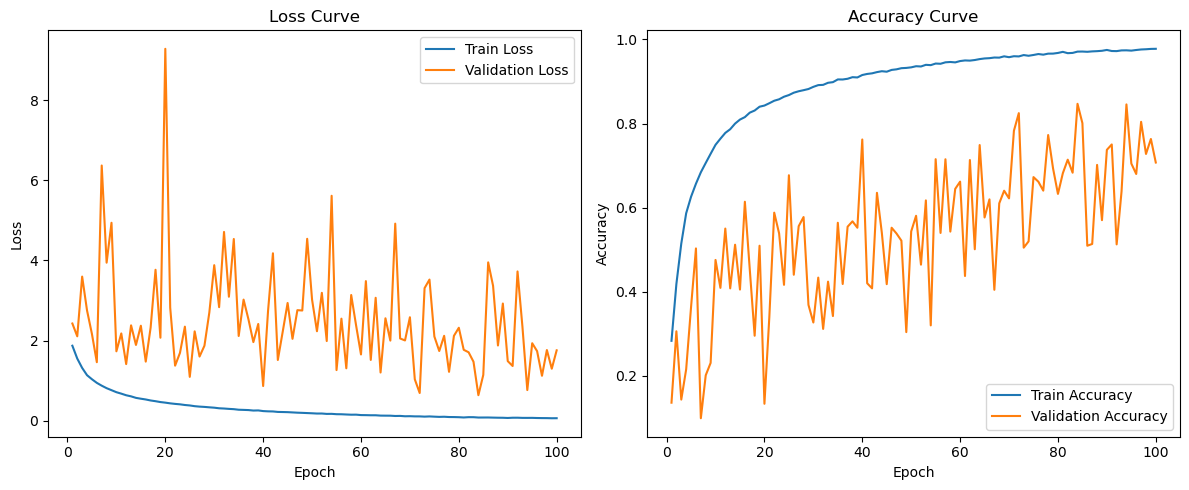

In [15]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, dev_losses, label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Curve")

plt.subplot(1,2,2)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, dev_accuracies, label='Validation Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy Curve")

plt.tight_layout()
plt.savefig("training_curve.png")
plt.show()


In [16]:
model.eval()  # 设置为评估模式
test_correct = 0
test_total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_accuracy = 100 * test_correct / test_total
print(f"Test Accuracy: {test_accuracy:.2f}%")

Test Accuracy: 70.13%


In [17]:
model2 = ResNetSmall(num_classes=10)
model2.load_state_dict(torch.load('best_model.pth'))
model2.to(device)
model2.eval()
test_correct = 0
test_total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model2(images)
        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_accuracy = 100 * test_correct / test_total
print(f"Test Accuracy: {test_accuracy:.2f}%")

Test Accuracy: 83.65%
